In [4]:
!pip uninstall en-core-web-sm==3.7.1
!pip uninstall albumentations==1.4.14
!pip install pip==23.3
!pip install https://huggingface.co/kenisgod/en_ingredient_extract/resolve/main/en_ingredient_extract-any-py3-none-any.whl

  Using cached https://huggingface.co/kenisgod/en_ingredient_extract/resolve/main/en_ingredient_extract-any-py3-none-any.whl (69 kB)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import spacy

In [6]:
df_train = pd.read_json("Dataset/train.json")
df_test = pd.read_json("Dataset/test.json")
nlp = spacy.load("en_ingredient_extract")
nltk.download('stopwords')
nltk.download('wordnet')

df_train.head(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli..."
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por..."
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-..."


# Preprocessing

In [7]:
df_train.describe()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


In [8]:
df_test.describe()

,id
count,9944.000000
mean,24894.350362
std,14322.958061
min,5.000000
25%,12541.000000
50%,24731.500000
75%,37113.250000
max,49715.000000


In [9]:
df_train.isna().describe()

,id,cuisine,ingredients
count,39774,39774,39774
unique,1,1,1
top,False,False,False
freq,39774,39774,39774


In [10]:
df_test.isna().describe()

,id,ingredients
count,9944,9944
unique,1,1
top,False,False
freq,9944,9944


In [11]:
df_train.isna().sum()

,0
id,0
cuisine,0
ingredients,0


In [12]:
df_test.isna().sum()

,0
id,0
ingredients,0


In [13]:
def NER(ingredients_list):
  ingredients=[]
  for phrase in ingredients_list:

    ent = nlp(phrase).ents

    for j in ent:
      ingredients.append(j.text)
  return ingredients

print(NER(df_train.iloc[1]['ingredients']))
df_train.iloc[1]['ingredients']



['pepper', 'salt', 'tomatoes', 'black pepper', 'thyme', 'eggs', 'tomatoes', 'corn meal', 'milk', 'vegetable oil']


['plain flour',
 'ground pepper',
 'salt',
 'tomatoes',
 'ground black pepper',
 'thyme',
 'eggs',
 'green tomatoes',
 'yellow corn meal',
 'milk',
 'vegetable oil']

Number of Unique Cuisines are:  20


,count
cuisine,
italian,7838
mexican,6438
southern_us,4320
indian,3003
chinese,2673
french,2646
cajun_creole,1546
thai,1539
japanese,1423


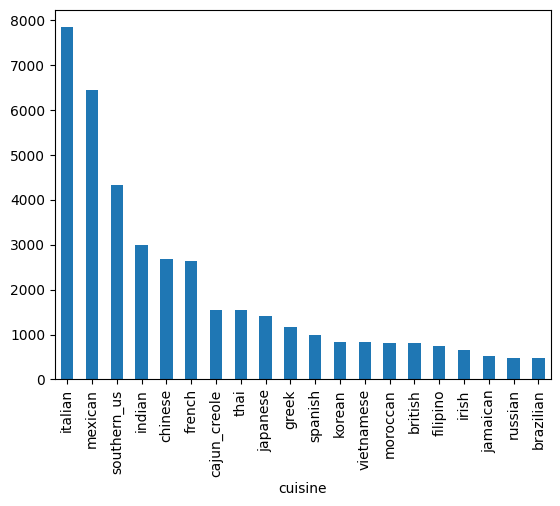

In [14]:
cuisine_freq = df_train["cuisine"].value_counts()

cuisine_freq.plot(kind="bar")
print("Number of Unique Cuisines are: ",len(cuisine_freq))
cuisine_freq


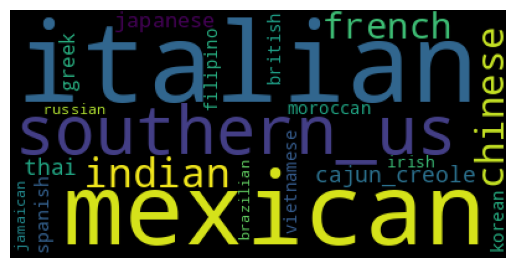

In [15]:
cuisine_freq_dict = cuisine_freq.to_dict()

wordcloud = WordCloud()
cuisine_wordcloud = wordcloud.generate_from_frequencies(cuisine_freq_dict)
plt.axis('off')
plt.imshow(cuisine_wordcloud)

In [16]:
ingredients_df = df_train.explode('ingredients')
ingredients_freq = ingredients_df['ingredients'].value_counts()


print("Number of Unique Ingredients are: ",len(ingredients_freq))
ingredients_freq

Number of Unique Ingredients are:  6714


,count
ingredients,
salt,18049
olive oil,7972
onions,7972
water,7457
garlic,7380
...,...
sauerkraut juice,1
no-calorie sweetener,1
Bob Evans Italian Sausage,1


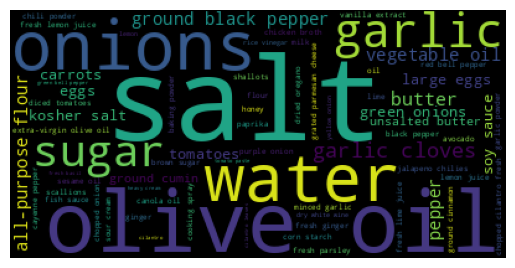

In [17]:
ingredients_freq_dict = ingredients_freq.to_dict()
ingredients_freq_wordcloud=wordcloud.generate_from_frequencies(ingredients_freq_dict)
plt.axis('off')
plt.imshow(ingredients_freq_wordcloud)

In [18]:
ingredients_by_cuisine = ingredients_df.groupby('cuisine')

ingredients_by_cuisine_freq = ingredients_by_cuisine['ingredients'].value_counts()

ingredients_by_cuisine_freq

cuisine     ingredients         
brazilian   salt                    194
            onions                  133
            olive oil               118
            lime                     89
            water                    87
                                   ... 
vietnamese  worcestershire sauce      1
            yam bean                  1
            yellow peppers            1
            yellow squash             1
            yukon gold potatoes       1
Name: count, Length: 29179, dtype: int64

In [19]:

#To do for pre-processing, i think:
#NER: The one from Assignment 1 is missing ingredients: confirm if we need to do NER or no.
#Rank freq all that plots from Assignment 1
#Freq-cuisine stuff from Assignment 2
#Create WordCloud/barplot/any visualisation, to see what ingredients are popular per cuisine - dont know how to use ingredients_by_cuisine_freq for that

In [20]:
def pre_process(ingredient_list):
    stop_words = set(stopwords.words("english"))
    word_lemmatizer = WordNetLemmatizer()
    cooking_words = {"organic","fresh","large","small","diced","chopped","minced","cup","spoon","chop","tablespoon","teaspoon","pinch","boiled","baked","grilled","steamed","sliced","whole","crushed","pureed","roasted","blended","mashed","peeled","shredded","cut","stirred","whisked","seared","toasted","frozen","softened","defrosted","grated","fried","drained","seasoned","marinated","garnished","glazed","caramelized","zested","dressed","broiled","cubed","poured","melted","scrambled","simmered","braised","browned","reduced","cooled","tossed"}
    ingridient_processed = []
    for ingredients in ingredient_list:
        final_ingredient = []
        split_list = ingredients.split(" ")
        for ingredient in split_list:
            ingredient = ingredient.strip()
            ingredient = re.sub(r'[^a-zA-Z\s]','',ingredient)
            if(ingredient in stop_words or ingredient in cooking_words):
#                 print(ingredient)
                continue
            else:

                ingredient = word_lemmatizer.lemmatize(ingredient)
                if(ingredient == ""):
                    continue
                final_ingredient.append(ingredient)
        if(len(final_ingredient) > 0):
            ingridient_processed.append(" ".join(final_ingredient))
#     print(ingridient_processed)
    return " ".join(ingridient_processed)


In [21]:
df_train["ingredients"] = df_train["ingredients"].map(pre_process)
df_test["ingredients"] = df_test["ingredients"].map(pre_process)

In [22]:
df_train.head()

,id,cuisine,ingredients
0,10259,greek,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,plain flour ground pepper salt tomato ground b...
2,20130,filipino,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallot cornflour cayenne pepper ...


In [23]:
df_test.head()

,id,ingredients
0,18009,baking powder egg allpurpose flour raisin milk...
1,28583,sugar egg yolk corn starch cream tartar banana...
2,41580,sausage link fennel bulb frond olive oil cuban...
3,29752,meat cut file powder smoked sausage okra shrim...
4,35687,ground black pepper salt sausage casing leek p...


In [24]:
X = df_train["ingredients"]
y = df_train["cuisine"]

le = LabelEncoder()
y = le.fit_transform(y)

tfid = TfidfVectorizer()
X = tfid.fit_transform(X)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [26]:
svm_model = SVC()
svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
print(f"SVM Accuracy : {accuracy_score(y_test,y_pred)}")


SVM Accuracy : 0.8021370207416719


In [31]:
from sklearn.model_selection import GridSearchCV,cross_val_score

param_grid = {'C': [0.1,1,10,50,100],
              'gamma': [0.01,0.1,1,10,100],
              'kernel': ['poly', 'rbf', 'sigmoid', 'precomputed', 'linear']}

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)


SVM_optimised = grid_search.best_estimator_
SVM_optimised.fit(X_train, y_train)


y_pred_SVM_optimised = SVM_optimised.predict(X_test)

accuracy_SVM_optimised = accuracy_score(y_test, y_pred_SVM_optimised)
cv_scores = cross_val_score(SVM_optimised, X_train, y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()

print(f"Optimized SVM Accuracy: {accuracy_SVM_optimised:.4f}")
print(
    f"5-Fold Cross-Validation Accuracy of Optimized Random Forest: {mean_cv_accuracy:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best parameters found: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Optimized SVM Accuracy: 0.8108
5-Fold Cross-Validation Accuracy of Optimized Random Forest: 0.8004
